In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin

In [2]:
# Julia language is required for SINDy-PI to be able to solve
# the differential algebraic equations (DAEs)
# Note that on my computer, at a terminal, I need to do:
# > julia  (enters the julia console)
# > import Pkg
# > Pkg.add("PyCall")
# > Pkg.add("DiffEqBase")
# > Pkg.add("DifferentialEquations")
# > exit()
# jupyter notebook (startup this notebook)

# Last thing to do (maybe specific to my installation)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

In [3]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')

In [4]:
# Define the analytic derivatives for each of the examples in this notebook

# Michaelis–Menten model for enzyme kinetics
def enzyme_deriv(x, t0, jx=0.6, Vmax=1.5, Km=0.3):
    return jx - Vmax * x / (Km + x)


# yeast glycolysis model, note that there are many typos in Kardy's paper for this eq'n
def yeast_deriv(x_y_z_t_u_v_w, t0, c1=2.5, c2=-100, c3=13.6769, d1=200, d2=13.6769,
                d3=-6, d4=-6, e1=6, e2=-64, e3=6, e4=16, f1=64, f2=-13, f3=13, f4=-16,
                f5=-100, g1=1.3, g2=-3.1, h1=-200, h2=13.6769, h3=128, h4=-1.28, h5=-32,
                j1=6, j2=-18, j3=-100):
    x, y, z, t, u, v, w = x_y_z_t_u_v_w
    return [c1 + c2 * x * v / (1 + c3 * v ** 4), 
            d1 * x * v / (1 + d2 * v ** 4) + d3 * y - d4 * y * w,
            e1 * y + e2 * z + e3 * y * w + e4 *z * v, 
            f1 * z + f2 * t + f3 *u + f4 * z * v + f5 * t * w,
            g1 * x + g2 * u, 
            h3 * z + h5 * v + h4 * z * w + h1 * x * v / (1 + h2 * v ** 4), 
            j1 * y + j2 * y * w + j3 * t * w]
    

# Cart on a pendulum
def pendulum_on_cart_deriv(w_x_y_z, t0, m=1, M=1, L1=1, L2=1, F=1, g=9.81):
    w, x, y, z = w_x_y_z
    return [y, z, 
            ((M + m) * g * np.sin(w) - F * np.cos(w) - m * L1 * np.sin(w) * np.cos(
                w) * y ** 2) / (L1 * (M + m * np.sin(w) ** 2)),
            (m * L1 * np.sin(w) * y ** 2 + F - m * g * np.sin(w) * np.cos(
                w)) / (M + m * np.sin(w) ** 2)]


# Control input models for kinematic single-track model
def f_steer(x, u1, min_sangle=-0.91, max_sangle=0.91, 
                   min_svel=-0.4, max_svel=0.4, 
                   min_vel=-13.9, max_vel=45.8,
                   switch_vel=4.755, amaz=11.5):
    return 0
    

def f_acc(y, u2, min_sangle=-0.91, max_sangle=0.91, 
                 min_svel=-0.4, max_svel=0.4, 
                 min_vel=-13.9, max_vel=45.8,
                 switch_vel=4.755, amaz=11.5):
    return 0
    

# CommonRoad kinematic single-track model
def kinematic_model(v_w_x_y_z, t0, u1, u2, amax=11.5, lwb=2.391):
    v, w, x, y, z = v_w_x_y_z
    return [y * cos(z),
            y * sin(z),
           f_steer(x, u1),
           f_acc(y, u2),
           y * np.tan(x) / lwb]


# Infamous double pendulum problem (frictionless if k1=k2=0)
def double_pendulum_deriv(w_x_y_z, t0, m1=0.2704, m2=0.2056, a1=0.191, a2=0.1621, L1=0.2667, L2=0.2667, 
                          I1=0.003, I2=0.0011, g=9.81, k1=0, k2=0):
    return [y, z, (L1 * a2 ** 2 * g * m2 ** 2 * np.sin(w) - 2 * L1 * a2 ** 3 * z **2 * m2 **2 * np.sin(
                w - x) + 2 * I2 * L1 * g * m2 * np.sin(w) + L1 * a2 **2 * g * m2 **2 *np.sin(
                w - 2 * x) + 2 * I2 * a1 * g * m1 * np.sin(w) - (L1 * a2 * y * m2) ** 2 * np.sin(
                2 * (w - x)) - 2 * I2 * L1 * a2 * z ** 2 * m2 * np.sin(
                w - x) + 2 * a1 * a2 ** 2 * g * m1 * m2 * np.sin(w)) / (2 * I1 * I2 + (L1 * a2 * m2
                ) ** 2 + 2 * I2 * L1 ** 2 * m2 + 2 * I2 * a1 ** 2 * m1 + 2 * I1 * a2 ** 2 * m2 - (
                L1 * a2 * m2) ** 2 * np.cos(2 * (w - x)) + 2 * (a1 * a2) ** 2 * m1 * m2), 
                (a2 * m2 * (2 * I1 * g * np.sin(
                x) + 2 * L1 ** 3 * y ** 2 * m2 * np.sin(w - x) + 2* L1 ** 2 * g * m2 * np.sin(x) + 2* I1 * L1 * y **2 * np.sin(
                w - x) + 2* a1 ** 2 * g * m1 * np.sin(x) + L1 ** 2 * a2 * z ** 2 * m2 * np.sin(
                 * (w - x)) + 2 * L1 * a1 ** 2 * y ** 2 * m1 * np.sin(w - x) - 2 * L1 ** 2 * g * m2 * np.cos(
                w - x) * np.sin(w) - 2 * L1 * a1 * g * m1 * np.cos(w - x) * np.sin(w))) / ( 2 * (
                I1 * I2 + (L1 * a2 * m2) ** 2 + I2 * L1 ** 2 * m2 + I2 * a1 ** 2 * m1 + I1 * a2 ** 2 * m2 - (L1 * a2 * m2) ** 2 * np.cos(
                w - x) ** 2 + a1 ** 2 * a2 ** 2 * m1 * m2))]


# Fix feature names
def fix_feature_names(feature_names, r):
    for i in range(len(feature_names)):
        if feature_names[i] == '':
            feature_names[i] = '1'
        for j in range(r):
            feature_names[i] = feature_names[i].replace("sin(x" + str(j) + ")", "sin(u[" + str(j) + "])*")  
            feature_names[i] = feature_names[i].replace("cos(x" + str(j) + ")", "cos(u[" + str(j) + "])*")
        for j in range(r):
            feature_names[i] = feature_names[i].replace("xdot" + str(j), "du[" + str(j) + "]*")  
            feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
        if feature_names[i][-1] == '*':
            feature_names[i] = feature_names[i][:-1]
        print(i, feature_names[i])
    return feature_names


# Function to build a symbolic DAE
# Extract the coefficients and build up a string to evaluate
def build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_index):
    full_string = ''
    for k in range(r):
        eval_string = ''
        for i in range(len(feature_names)):
            eval_string += 'coefs[' + str(i) + ', ' + str(k) + '] * eval(feature_names[' + str(i) + '])'
            if i != len(feature_names) - 1:
                eval_string += ' + '
            else:
                eval_string += ' - eval(feature_names[' + str(coef_index + k) + '])' # du[' + str(k) + ']'
        # Okay, now have the eval string for one of the ODEs and need to string together
        if k == 0 and r == 1:
            full_string = eval_string
        elif k == 0:
            full_string += '[' + eval_string + ', '
        elif k != 0 and k != r - 1:
            full_string += eval_string + ', '
        elif k != 0 and k == r - 1:
            full_string += eval_string + ']'
    return full_string


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ full_coefficients, axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [5]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0_train = np.random.rand(r) - 0.5
x_train = integrate.odeint(enzyme_deriv, x0_train, t)
x0_test = np.random.rand(r)
x_test = integrate.odeint(enzyme_deriv, x0_test, t)

# define hyperparameters
threshold = 1e-3

fd = FiniteDifference(drop_endpoints=False)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t)) # * dt)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t)) # * dt)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# max_iter = 10000 is the default values used for cvxpy
# and differs from the normal definition in PySINDy
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(499, 1)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 519, constraints m = 520
          nnz(P) + nnz(A) = 6029
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1851e-04   1.00e+00   3.37e+04   1.00e-01   6.22e-04s
 100   7.9443e-03   5.90e-06   1.08e-08   2.30e-03   3.63e-03s

status:               solved
solut

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 519, constraints m = 520
          nnz(P) + nnz(A) = 6029
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1851e-04   1.19e-02   2.86e-01   1.00e-01   6.21e-04s
  25   8.0813e-08   9.48e-06   1.36e-06   1.00e-01   1.20e-03s

status:               solved
solution polis

SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7fd3a1786110>,
      feature_names=['x0'],
      optimizer=SINDyPIoptimizer(max_iter=20000, threshold=0.001))

0 1
1 du[0]
2 u[0]
3 u[0]*du[0]
4 u[0]*u[0]
5 u[0]*u[0]*du[0]
6 u[0]*u[0]*u[0]
7 u[0]*u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*u[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
(10, 1) du[0]


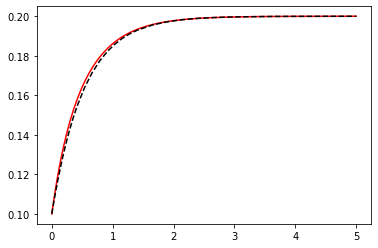

In [6]:
coef_index = 1
coefs = (sindy_opt.coef_)[:, coef_index: coef_index + r]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_index)
print(coefs.shape, feature_names[coef_index])

# Define a SINDy differential algebraic equation (DAE)
def SINDy_model(du, u, p, t):
    resid = eval(eval_string)
    return resid


u0 = [0.1]
du0 = [-0.04]
tspan = (0.0,5.0)
differential_vars = [True]
prob = de.DAEProblem(SINDy_model, du0, u0, tspan, differential_vars=differential_vars)
plt.plot(t, integrate.odeint(enzyme_deriv, u0[0], t), 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')

In [7]:
# define parameters
r = 4
dt = 0.025
T = 50
t = np.arange(0, T + dt, dt)

x0_train = [0.3, 0, 1, 0]
x_train = integrate.odeint(pendulum_on_cart_deriv, x0_train, t)
x0_test = [np.pi, 0, 0, 0]
x_test = integrate.odeint(pendulum_on_cart_deriv, x0_test, t)

# define hyperparameters
threshold = 1e3

xdot_train = np.nan_to_num(fd._differentiate(x_train, t))
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))

x_library_functions = [lambda x:1, lambda x:x, lambda x:cos(x), lambda x:sin(x),
                       lambda x: sin(x) * sin(x), lambda x: sin(x) * cos(x)]
xdot_library_functions = [lambda x:1, lambda x:x, lambda x:x ** 2]
        
library_function_names = [lambda x:'', lambda x:x, lambda x:'cos(' + x + ')', lambda x: 'sin(' + x + ')',
                          lambda x: 'sin(' + x + ')' + 'sin(' + x + ')', 
                          lambda x: 'sin(' + x + ')' + 'cos(' + x + ')',
                          lambda x:'', lambda x:x, lambda x: x + x] 

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=2000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
print(model.get_feature_names())
print(np.shape(model.get_feature_names()))
print(np.shape(sindy_opt.Theta), np.shape(sindy_opt.coef_))
# print(sindy_opt.coef_)

(1999, 4)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+06   8.00e+00   1.14e+09   1.00e-01   1.16e-01s
 200   1.6692e+02   9.55e-05   2.73e-01   7.48e+00   6.34e-01s
 400   1.6695e+02   4.63e-05  

 200   1.0055e+03   5.70e-04   1.38e-01   1.32e+00   7.19e-01s
 225   1.0055e+03   5.42e-04   7.13e-03   1.32e+00   7.61e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 225
optimal objective:    1005.4950
run time:             8.75e-01s
optimal rho estimate: 5.54e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          sca

 200   3.8453e+03   4.51e-03   1.09e+00   7.87e-01   5.47e-01s
 400   3.9134e+03   1.28e-03   1.32e-01   7.87e-01   8.96e-01s
 600   3.9203e+03   7.33e-04   3.06e-02   7.87e-01   1.25e+00s
 800   3.9222e+03   2.55e-04   1.55e-02   7.87e-01   1.59e+00s
 825   3.9223e+03   2.55e-04   6.01e-03   7.87e-01   1.64e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 825
optimal objective:    3922.2793
run time:             1.75e+00s
optimal rho estimate: 3.31e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 

 200   1.5449e+07   6.33e-01   6.35e+00   1.20e-02   5.43e-01s
 400   1.5448e+07   7.96e-01   2.06e+00   1.20e-02   8.94e-01s
 600   1.5448e+07   5.13e-01   7.11e-01   1.20e-02   1.24e+00s
 800   1.5448e+07   1.62e-01   1.14e-01   1.20e-02   1.59e+00s
1000   1.5448e+07   2.46e-02   3.90e-02   1.20e-02   1.93e+00s
1200   1.5448e+07   2.31e-02   3.11e-02   1.20e-02   2.28e+00s
1400   1.5448e+07   2.16e-02   2.48e-02   1.20e-02   2.63e+00s
1600   1.5449e+07   3.11e-03   2.18e-02   6.04e-02   3.07e+00s
1800   1.5449e+07   3.11e-03   1.96e-02   6.04e-02   3.41e+00s
2000   1.5449e+07   3.10e-03   1.84e-02   6.04e-02   3.76e+00s
2200   1.5449e+07   3.09e-03   1.77e-02   6.04e-02   4.11e+00s
2400   1.5449e+07   3.09e-03   1.71e-02   6.04e-02   4.46e+00s
2600   1.5449e+07   9.93e-04   1.62e-02   6.04e-02   4.81e+00s
2800   1.5449e+07   9.93e-04   1.56e-02   6.04e-02   5.16e+00s
3000   1.5449e+07   9.93e-04   1.50e-02   6.04e-02   5.51e+00s
3200   1.5449e+07   9.93e-04   1.44e-02   6.04e-02   5.

 200   1.0539e+04   7.53e-03   5.40e-02   1.00e-01   4.61e-01s
 400   1.0622e+04   4.57e-03   6.62e-01   5.20e-01   9.01e-01s
 600   1.0642e+04   1.38e-03   5.72e-02   5.20e-01   1.25e+00s
 700   1.0646e+04   1.17e-03   8.48e-03   5.20e-01   1.42e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 700
optimal objective:    10646.0042
run time:             1.53e+00s
optimal rho estimate: 1.89e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (ada

2200   4.7662e+06   1.17e-02   4.23e-02   3.47e-02   4.09e+00s
2400   4.7662e+06   4.62e-03   3.48e-02   3.47e-02   4.44e+00s
2600   4.7662e+06   4.57e-03   2.80e-02   3.47e-02   4.78e+00s
2800   4.7662e+06   4.51e-03   2.23e-02   3.47e-02   5.13e+00s
3000   4.7662e+06   4.45e-03   1.77e-02   3.47e-02   5.48e+00s
3200   4.7662e+06   3.80e-03   1.41e-02   3.47e-02   5.83e+00s
3400   4.7662e+06   3.80e-03   1.11e-02   3.47e-02   6.17e+00s
3500   4.7662e+06   3.80e-03   9.84e-03   3.47e-02   6.35e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 3500
optimal objective:    4766248.5707
run time:             6.46e+00s
optimal rho estimate: 7.51e-02

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
proble

 200   2.2895e+08   2.00e+01   9.37e+00   6.19e-03   5.49e-01s
 400   2.2892e+08   1.19e+00   2.48e+00   6.19e-03   9.00e-01s
 600   2.2893e+08   9.54e-02   4.87e-01   6.19e-03   1.25e+00s
 800   2.2893e+08   9.53e-02   4.96e-01   6.19e-03   1.59e+00s
1000   2.2893e+08   9.51e-02   4.86e-01   6.19e-03   1.94e+00s
1200   2.2893e+08   5.99e-02   4.81e-01   6.19e-03   2.29e+00s
1400   2.2893e+08   1.09e-02   4.74e-01   6.19e-03   2.63e+00s
1600   2.2893e+08   1.06e-02   4.68e-01   6.19e-03   2.98e+00s
1800   2.2893e+08   1.04e-02   4.62e-01   6.19e-03   3.32e+00s
2000   2.2893e+08   1.03e-02   4.56e-01   6.19e-03   3.67e+00s
2200   2.2893e+08   1.02e-02   4.51e-01   6.19e-03   4.02e+00s
2400   2.2893e+08   1.00e-02   4.45e-01   6.19e-03   4.36e+00s
2600   2.2893e+08   9.90e-03   4.39e-01   6.19e-03   4.71e+00s
2775   2.2893e+08   1.45e-02   2.30e-02   6.19e-03   5.02e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 2775
optimal objective:    2289

 200   1.3652e+05   1.33e-02   1.94e+00   1.32e-01   6.37e-01s
 375   1.3665e+05   6.42e-03   9.63e-03   1.32e-01   9.41e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 375
optimal objective:    136654.5538
run time:             1.05e+00s
optimal rho estimate: 7.92e-01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          s

 200   1.8876e+02   6.57e-05   2.40e-01   7.68e+00   6.35e-01s
 400   1.8886e+02   4.65e-05   1.45e-02   7.68e+00   9.85e-01s
 600   1.8913e+02   2.99e-05   1.75e-01   4.59e+01   1.42e+00s
 650   1.8918e+02   1.97e-05   5.55e-03   7.38e+00   1.60e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 650
optimal objective:    189.1845
run time:             1.71e+00s
optimal rho estimate: 2.15e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adapt

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+06   2.79e+01   1.67e+08   1.00e-01   1.13e-01s
 200   7.5697e+03   5.13e-04   1.99e-01   2.03e+00   5.47e-01s
 400   7.5718e+03   3.24e-04   1.13e-02 

 200   1.1990e+03   6.00e-04   1.36e-01   4.23e+00   6.34e-01s
 400   1.2029e+03   1.23e-04   3.17e-01   2.13e+01   1.07e+00s
 600   1.2033e+03   3.04e-05   8.60e-03   2.13e+01   1.41e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 600
optimal objective:    1203.2870
run time:             1.53e+00s
optimal rho estimate: 4.37e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 100

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+06   6.79e+02   3.28e+10   1.00e-01   1.13e-01s
 200   6.0279e+03   1.08e-02   3.77e-02   1.04e-01   6.41e-01s
 400   6.1008e+03   2.14e-03   1.30e-01 

 200   1.2461e+03   2.50e-03   1.08e-01   1.26e+00   5.49e-01s
 400   1.2596e+03   2.03e-04   1.03e+00   8.87e+00   9.91e-01s
 600   1.2608e+03   9.47e-05   1.20e-02   8.87e+00   1.34e+00s
 700   1.2610e+03   7.66e-05   5.68e-03   8.87e+00   1.51e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 700
optimal objective:    1260.9985
run time:             1.62e+00s
optimal rho estimate: 2.07e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adap

 200   4.8937e+05   1.60e-02   4.05e-01   1.27e-01   6.39e-01s
 400   4.8964e+05   2.87e-03   1.53e+00   9.20e-01   1.08e+00s
 600   4.8967e+05   9.66e-04   3.33e-02   9.20e-01   1.43e+00s
 650   4.8967e+05   5.18e-04   3.73e-03   9.20e-01   1.52e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 650
optimal objective:    489666.2667
run time:             1.63e+00s
optimal rho estimate: 4.35e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (ad

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+06   2.54e+01   4.44e+08   1.00e-01   1.11e-01s
 175   1.2228e+03   3.49e-05   8.66e-03   1.19e+01   5.86e-01s

status:               solved
solution p

 200   1.7650e+04   1.33e-03   4.33e-01   1.32e+00   5.54e-01s
 400   1.7665e+04   2.21e-04   1.37e+00   6.81e+00   9.95e-01s
 600   1.7666e+04   1.10e-04   1.52e-02   6.81e+00   1.35e+00s
 650   1.7666e+04   5.28e-05   8.83e-03   6.81e+00   1.44e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 650
optimal objective:    17666.0278
run time:             1.55e+00s
optimal rho estimate: 1.36e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (ada

 200   2.2476e+04   2.58e-03   9.89e-01   6.50e-01   5.48e-01s
 400   2.2514e+04   6.99e-04   1.02e+00   3.45e+00   9.85e-01s
 500   2.2516e+04   2.51e-04   9.53e-03   3.45e+00   1.16e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 500
optimal objective:    22515.5059
run time:             1.27e+00s
optimal rho estimate: 1.28e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10

 200   1.8655e+06   1.66e-01   2.47e-01   9.19e-03   5.48e-01s
 400   1.8660e+06   8.46e-02   3.39e-01   9.19e-03   8.97e-01s
 600   1.8665e+06   1.26e-02   5.17e-01   1.18e-01   1.33e+00s
 800   1.8666e+06   4.61e-03   1.01e-02   1.18e-01   1.68e+00s
 875   1.8666e+06   4.61e-03   1.00e-02   1.18e-01   1.81e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 875
optimal objective:    1866607.5065
run time:             1.92e+00s
optimal rho estimate: 3.23e-01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf

 200   2.5817e+04   1.81e-02   1.12e-01   1.21e-01   6.36e-01s
 400   2.5920e+04   6.65e-03   5.68e-01   1.21e-01   9.85e-01s
 575   2.5984e+04   4.07e-03   5.44e-03   1.21e-01   1.29e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 575
optimal objective:    25983.6925
run time:             1.39e+00s
optimal rho estimate: 8.21e-01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10

 200   1.5106e+02   3.91e-05   8.41e-02   4.99e+01   7.21e-01s
 400   1.5144e+02   1.45e-05   1.87e-01   4.99e+01   1.07e+00s
 525   1.5151e+02   1.05e-05   8.52e-03   4.99e+01   1.29e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 525
optimal objective:    151.5060
run time:             1.40e+00s
optimal rho estimate: 9.60e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 1000

 150   2.7649e+03   8.48e-05   1.76e-03   9.17e+00   5.47e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 150
optimal objective:    2764.8618
run time:             6.59e-01s
optimal rho estimate: 7.66e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, pol

 200   2.8734e+03   1.81e-03   8.88e-02   9.17e-01   5.48e-01s
 400   2.8891e+03   2.71e-04   4.05e-02   6.18e+00   9.90e-01s
 475   2.8905e+03   1.50e-04   8.97e-03   6.18e+00   1.12e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 475
optimal objective:    2890.4607
run time:             1.23e+00s
optimal rho estimate: 1.91e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 100

3200   1.9322e+05   4.37e-03   1.11e-02   5.04e-03   6.01e+00s
3400   1.9322e+05   4.30e-03   1.08e-02   5.04e-03   6.36e+00s
3600   1.9322e+05   4.22e-03   1.06e-02   5.04e-03   6.71e+00s
3800   1.9322e+05   4.14e-03   1.03e-02   5.04e-03   7.06e+00s
4000   1.9322e+05   4.06e-03   1.01e-02   5.04e-03   7.40e+00s
4075   1.9322e+05   4.03e-03   1.00e-02   5.04e-03   7.53e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 4075
optimal objective:    193223.0728
run time:             7.64e+00s
optimal rho estimate: 5.87e-03

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
       

 600   1.3533e+05   1.24e-03   1.14e-01   7.30e-01   1.25e+00s
 625   1.3533e+05   1.17e-03   6.60e-03   7.30e-01   1.30e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 625
optimal objective:    135334.6710
run time:             1.41e+00s
optimal rho estimate: 3.67e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          s

 200   1.2394e+05   1.33e-02   2.49e-01   1.00e-01   4.60e-01s
 400   1.2418e+05   2.77e-03   1.95e+00   6.38e-01   8.98e-01s
 450   1.2418e+05   9.44e-04   6.55e-03   6.38e-01   9.85e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 450
optimal objective:    124178.7841
run time:             1.09e+00s
optimal rho estimate: 2.81e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 1

 200   5.0494e+02   3.62e-05   3.35e-01   2.33e+01   6.41e-01s
 350   5.0505e+02   1.76e-05   4.53e-03   2.33e+01   9.04e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 350
optimal objective:    505.0461
run time:             1.01e+00s
optimal rho estimate: 7.39e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scal

 200   4.6911e+02   6.80e-04   6.10e-01   6.45e+00   6.36e-01s
 400   4.7274e+02   7.44e-05   1.58e-02   6.45e+00   9.94e-01s
 600   4.7320e+02   3.72e-05   1.95e-01   3.27e+01   1.43e+00s
 800   4.7334e+02   2.06e-05   8.81e-03   3.27e+01   1.78e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 800
optimal objective:    473.3437
run time:             1.89e+00s
optimal rho estimate: 8.29e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adapt

 200   5.2865e+03   4.03e-04   9.89e-02   4.68e+00   5.54e-01s
 400   5.2902e+03   1.57e-04   6.85e-01   4.68e+00   9.12e-01s
 575   5.2909e+03   5.05e-05   4.79e-03   3.99e+00   1.40e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 575
optimal objective:    5290.9102
run time:             1.50e+00s
optimal rho estimate: 1.04e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 100

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+06   3.75e+02   3.30e+09   1.00e-01   1.14e-01s
 200   1.0752e+05   1.49e-02   1.66e-02   1.00e-01   4.67e-01s
 400   1.0780e+05   4.97e-04   1.19e+00 

 200   2.3427e+04   1.82e-03   1.62e+00   1.02e+00   5.52e-01s
 400   2.3445e+04   2.73e-04   6.16e-02   7.04e+00   9.91e-01s
 450   2.3446e+04   1.74e-04   8.64e-03   7.04e+00   1.08e+00s

status:               solved
solution polish:      unsuccessful
number of iterations: 450
optimal objective:    23445.6844
run time:             1.19e+00s
optimal rho estimate: 3.33e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2377, constraints m = 2378
          nnz(P) + nnz(A) = 382566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10

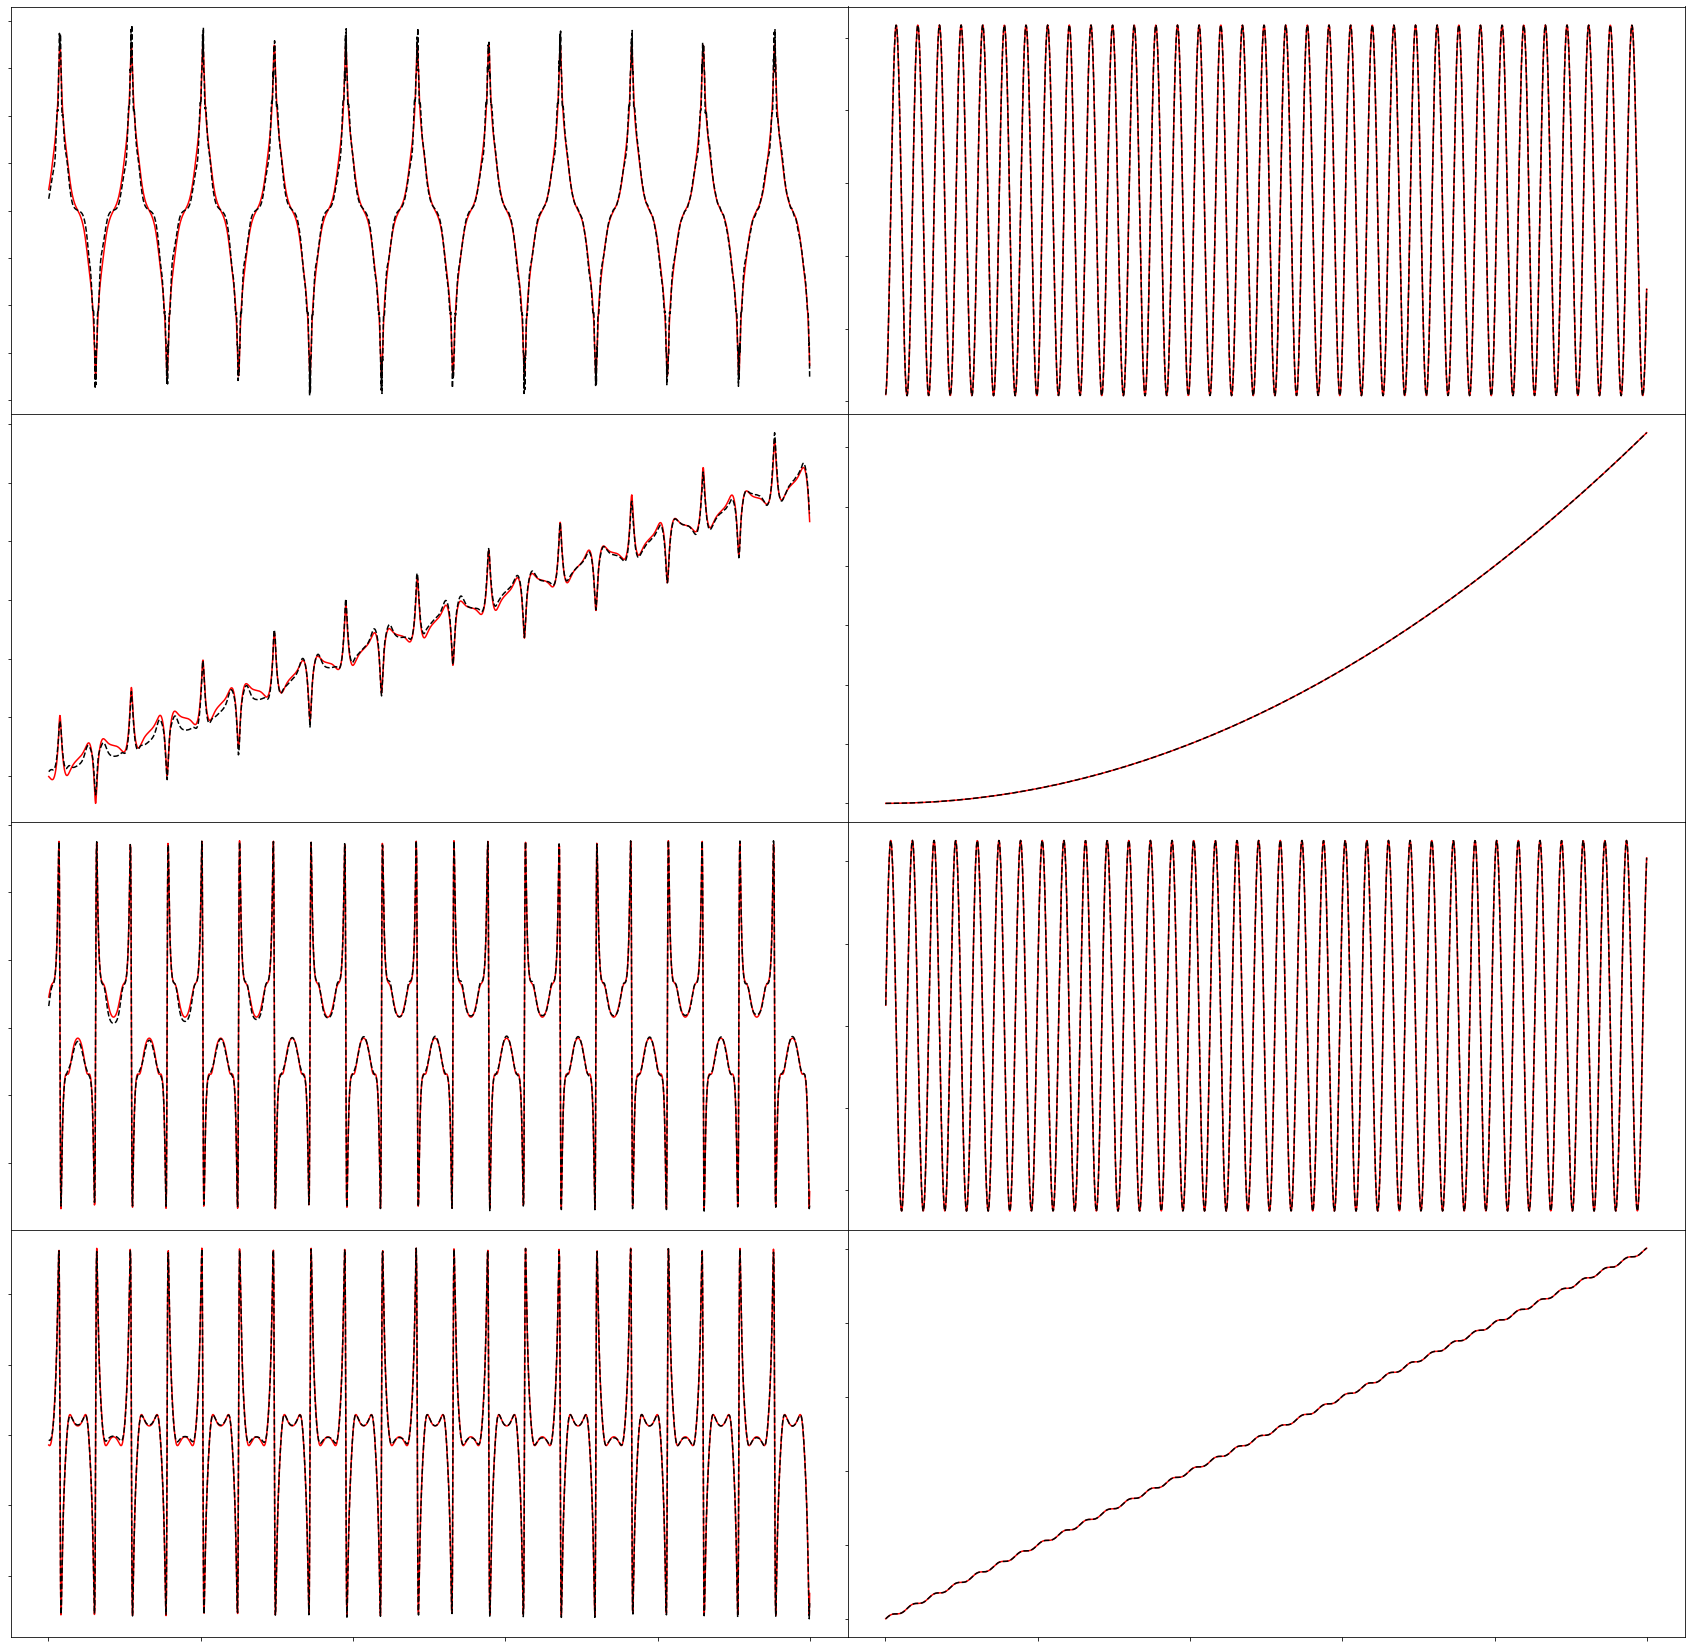

In [8]:
xdot_test = model.differentiate(x_train, t=t)[1:-1, :]
xdot_test_pred = sindy_opt.Theta @ sindy_opt.coef_
make_fits(r, t[1:-1], xdot_test, xdot_test_pred[:, 1:1+r], x_test[1:-1], x_test[1:-1], 'pendulum_on_cart')

In [10]:
coef_index = 1
r = 4
coefs = (sindy_opt.coef_)[:, coef_index: coef_index + r]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_index)
print(eval_string, np.shape(coefs))

# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = x0_train  #np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 50)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)

colors = ['r', 'b', 'g', 'k']
x_test = integrate.odeint(pendulum_on_cart_deriv, u0, t)
for i in range(r):
    plt.plot(t, x_test[:, i], colors[i], label=str(i))
    plt.plot(sol.t, np.asarray(sol.u)[:, i], colors[i] + '--')
plt.legend()

0 1
1 du[0]
2 du[1]
3 du[2]
4 du[3]
5 du[0]*du[0]
6 du[1]*du[1]
7 du[2]*du[2]
8 du[3]*du[3]
9 u[0]
10 u[1]
11 u[2]
12 u[3]
13 u[0]*du[0]
14 u[0]*du[1]
15 u[0]*du[2]
16 u[0]*du[3]
17 u[1]*du[0]
18 u[1]*du[1]
19 u[1]*du[2]
20 u[1]*du[3]
21 u[2]*du[0]
22 u[2]*du[1]
23 u[2]*du[2]
24 u[2]*du[3]
25 u[3]*du[0]
26 u[3]*du[1]
27 u[3]*du[2]
28 u[3]*du[3]
29 u[0]*du[0]*du[0]
30 u[0]*du[1]*du[1]
31 u[0]*du[2]*du[2]
32 u[0]*du[3]*du[3]
33 u[1]*du[0]*du[0]
34 u[1]*du[1]*du[1]
35 u[1]*du[2]*du[2]
36 u[1]*du[3]*du[3]
37 u[2]*du[0]*du[0]
38 u[2]*du[1]*du[1]
39 u[2]*du[2]*du[2]
40 u[2]*du[3]*du[3]
41 u[3]*du[0]*du[0]
42 u[3]*du[1]*du[1]
43 u[3]*du[2]*du[2]
44 u[3]*du[3]*du[3]
45 cos(u[0])
46 cos(u[1])
47 cos(u[2])
48 cos(u[3])
49 cos(u[0])*du[0]
50 cos(u[0])*du[1]
51 cos(u[0])*du[2]
52 cos(u[0])*du[3]
53 cos(u[1])*du[0]
54 cos(u[1])*du[1]
55 cos(u[1])*du[2]
56 cos(u[1])*du[3]
57 cos(u[2])*du[0]
58 cos(u[2])*du[1]
59 cos(u[2])*du[2]
60 cos(u[2])*du[3]
61 cos(u[3])*du[0]
62 cos(u[3])*du[1]
63 cos(u[3])*du

RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: MethodError: no method matching Sundials.FunJac(::Sundials.var"#105#109"{SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}, Tuple{Int64}, Tuple{Int64}}, ::Nothing, ::Nothing, ::SciMLBase.NullParameters, ::Nothing, ::Nothing, ::Nothing, ::Nothing, ::Vector{Real}, ::Vector{Float64}, ::Vector{Float64})
Closest candidates are:
  Sundials.FunJac(::F, ::F2, ::J, ::P, ::M, ::J2, ::Prec, ::PS, ::uType, !Matched::uType, ::uType2) where {F, F2, J, P, M, J2, uType, uType2, Prec, PS} at /usr/local/anaconda3/share/julia/site/packages/Sundials/YfkdE/src/common_interface/function_types.jl:3
  Sundials.FunJac(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) at /usr/local/anaconda3/share/julia/site/packages/Sundials/YfkdE/src/common_interface/function_types.jl:17
  Sundials.FunJac(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) at /usr/local/anaconda3/share/julia/site/packages/Sundials/YfkdE/src/common_interface/function_types.jl:15
Stacktrace:
  [1] Sundials.FunJac(fun::Function, jac::Nothing, p::SciMLBase.NullParameters, m::Nothing, jac_prototype::Nothing, prec::Nothing, psetup::Nothing, u::Vector{Real}, du::Vector{Float64}, resid::Vector{Float64})
    @ Sundials /usr/local/anaconda3/share/julia/site/packages/Sundials/YfkdE/src/common_interface/function_types.jl:17
  [2] __init(prob::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}, alg::Sundials.IDA{:Dense, Nothing, Nothing}, timeseries::Vector{Any}, ts::Vector{Any}, ks::Vector{Any}; verbose::Bool, dt::Nothing, dtmax::Float64, save_on::Bool, save_start::Bool, callback::Nothing, abstol::Float64, reltol::Float64, saveat::Vector{Float64}, tstops::Vector{Float64}, maxiters::Int64, timeseries_errors::Bool, dense_errors::Bool, save_everystep::Bool, dense::Bool, save_timeseries::Nothing, save_end::Bool, progress::Bool, progress_name::String, progress_message::typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), advance_to_tstop::Bool, stop_at_next_tstop::Bool, userdata::Nothing, kwargs::Base.Iterators.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:default_set, :second_time), Tuple{Bool, Bool}}})
    @ Sundials /usr/local/anaconda3/share/julia/site/packages/Sundials/YfkdE/src/common_interface/solve.jl:1136
  [3] __solve(prob::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}, alg::Sundials.IDA{:Dense, Nothing, Nothing}, timeseries::Vector{Any}, ts::Vector{Any}, ks::Vector{Any}, recompile::Type{Val{true}}; kwargs::Base.Iterators.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:default_set, :second_time), Tuple{Bool, Bool}}})
    @ Sundials /usr/local/anaconda3/share/julia/site/packages/Sundials/YfkdE/src/common_interface/solve.jl:13
  [4] __solve(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}, ::Nothing; default_set::Bool, kwargs::Base.Iterators.Pairs{Symbol, Bool, Tuple{Symbol}, NamedTuple{(:second_time,), Tuple{Bool}}})
    @ DifferentialEquations /usr/local/anaconda3/share/julia/site/packages/DifferentialEquations/el96s/src/default_solve.jl:7
  [5] __solve(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}; default_set::Bool, second_time::Bool, kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ DiffEqBase /usr/local/anaconda3/share/julia/site/packages/DiffEqBase/niZxn/src/solve.jl:285
  [6] __solve(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}})
    @ DiffEqBase /usr/local/anaconda3/share/julia/site/packages/DiffEqBase/niZxn/src/solve.jl:272
  [7] solve_call(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}; merge_callbacks::Bool, kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ DiffEqBase /usr/local/anaconda3/share/julia/site/packages/DiffEqBase/niZxn/src/solve.jl:61
  [8] solve_call(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}})
    @ DiffEqBase /usr/local/anaconda3/share/julia/site/packages/DiffEqBase/niZxn/src/solve.jl:48
  [9] solve_up(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}, ::Nothing, ::Vector{Real}, ::SciMLBase.NullParameters; kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ DiffEqBase /usr/local/anaconda3/share/julia/site/packages/DiffEqBase/niZxn/src/solve.jl:88
 [10] solve_up(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}, ::Nothing, ::Vector{Real}, ::SciMLBase.NullParameters)
    @ DiffEqBase /usr/local/anaconda3/share/julia/site/packages/DiffEqBase/niZxn/src/solve.jl:78
 [11] solve(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}; sensealg::Nothing, u0::Nothing, p::Nothing, kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ DiffEqBase /usr/local/anaconda3/share/julia/site/packages/DiffEqBase/niZxn/src/solve.jl:73
 [12] solve(::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}})
    @ DiffEqBase /usr/local/anaconda3/share/julia/site/packages/DiffEqBase/niZxn/src/solve.jl:68
 [13] (::PyCall.var"#64#70"{PyCall.var"#64#65#71"{typeof(CommonSolve.solve)}})(args::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}; kws::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ PyCall /usr/local/anaconda3/share/julia/site/packages/PyCall/BD546/src/callback.jl:98
 [14] (::PyCall.var"#64#70"{PyCall.var"#64#65#71"{typeof(CommonSolve.solve)}})(args::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}})
    @ PyCall /usr/local/anaconda3/share/julia/site/packages/PyCall/BD546/src/callback.jl:98
 [15] (::PyCall.FuncWrapper{Tuple{Vararg{PyAny, N} where N}, PyCall.var"#64#70"{PyCall.var"#64#65#71"{typeof(CommonSolve.solve)}}})(args::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}}; kws::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ PyCall /usr/local/anaconda3/share/julia/site/packages/PyCall/BD546/src/callback.jl:56
 [16] (::PyCall.FuncWrapper{Tuple{Vararg{PyAny, N} where N}, PyCall.var"#64#70"{PyCall.var"#64#65#71"{typeof(CommonSolve.solve)}}})(args::SciMLBase.DAEProblem{Vector{Real}, Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.DAEFunction{false, PyObject, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Vector{Bool}})
    @ PyCall /usr/local/anaconda3/share/julia/site/packages/PyCall/BD546/src/callback.jl:56
 [17] invokelatest(::Any, ::Any, ::Vararg{Any, N} where N; kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ Base ./essentials.jl:708
 [18] invokelatest(::Any, ::Any, ::Vararg{Any, N} where N)
    @ Base ./essentials.jl:706
 [19] _pyjlwrap_call(f::PyCall.FuncWrapper{Tuple{Vararg{PyAny, N} where N}, PyCall.var"#64#70"{PyCall.var"#64#65#71"{typeof(CommonSolve.solve)}}}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall /usr/local/anaconda3/share/julia/site/packages/PyCall/BD546/src/callback.jl:28
 [20] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall /usr/local/anaconda3/share/julia/site/packages/PyCall/BD546/src/callback.jl:44>

In [ ]:
# These are the four coefficients we ideally want
print(feature_names[1], sindy_opt.coef_[3, 1])
print(feature_names[2], sindy_opt.coef_[4, 2])
print(feature_names[123])
print(feature_names[124])

coef_indices = [1, 2, 123, 124]
r = 4
coefs = (sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_index)
u0 = np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 2)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')
print(sol)